<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_IA/blob/main/08_deep_learning/tp_01_v07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
#import tensorflow.keras.optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import keras as keras
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn import metrics
import math
from tensorflow.keras.regularizers import l2
import seaborn as sns
from sklearn.decomposition import PCA

In [ ]:
#!pip install tensorflow

In [54]:
## column to predict
y_col = 'TotalScore'

## lsit of columns to exclude
list_cols_exclude = ['GameID']

list_cols_exclude_aug = ['GameID', 'ScenarioID']


In [55]:
### create dataframe from csv
def get_df_from_csv(p_path
                    , p_sep=','
                    , p_cols_excl=None
                    , p_custom_column_names=None
                    , p_print=True
                    ):
    if p_custom_column_names is None:
        # Read CSV with header (default behavior)
        df = pd.read_csv(p_path, sep=p_sep)
    else:
        # Read CSV without header and assign custom column names
        df = pd.read_csv(p_path, sep=p_sep, header=None, names=p_custom_column_names)

    if p_cols_excl is not None:
      df = df.drop(p_cols_excl, axis=1)


    if p_print:
        print('---Head---')
        print(df.head())
        print('-- How many nulls? --')
        print(df.isna().sum())
        print('---shape--')
        print(df.shape)

    return df

In [56]:
## Augmented df
def get_augmented_df(p_cols_excl=list_cols_exclude_aug):
  ## head 400001
  path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/AugmentedData_reduced.csv"
  augmented_df_1 = get_df_from_csv(path_csv
                                   , p_sep =","
                                   #, p_cols_excl=list_cols_exclude_aug
                                   )
  print("shape:", augmented_df_1.shape)

  ## tail 284000
  path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/AugemntedData_reduced_tail.csv"
  augmented_df_2 = get_df_from_csv(path_csv
                                   , p_sep =","
                                   #, p_cols_excl=list_cols_exclude_aug
                                   , p_custom_column_names = augmented_df_1.columns
                                   )

  df_return = pd.concat([augmented_df_1, augmented_df_2], axis=0, ignore_index=True)
  #print("[p_cols_excl]: ", p_cols_excl)
  #print("df_return["+ p_cols_excl[0]+"]")
  #print("df_return["+ p_cols_excl[1]+"]")
  df_return = df_return.drop(p_cols_excl, axis=1)
  print("shape: ", df_return.shape)

  return df_return

In [57]:
## Original df
path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/OriginalData.csv"
original_df = get_df_from_csv(path_csv, p_sep =",", p_cols_excl=list_cols_exclude)

---Head---
   Hole1  Hole2  Hole3  Hole4  Hole5  Hole6  Hole7  Hole8  Hole9  Hole10  \
0      4      6      5      4      6      5      5      3      5       4   
1      3      5      4      4      5      5      6      3      4       5   
2      5      4      6      4      7      4      5      3      5       6   
3      4      4      7      3      6      4      4      4      5       7   
4      4      7      6      4      5      4      5      3      4       6   

   Hole11  Hole12  Hole13  Hole14  Hole15  Hole16  Hole17  Hole18  TotalScore  
0       5       4       4       6       4       5       4       6          85  
1       5       5       4       5       3       4       3       4          77  
2       6       5       4       5       3       5       3       3          83  
3       5       7       4       6       3       6       3       4          86  
4       9       6       3       5       4       5       3       4          87  
-- How many nulls? --
Hole1         0
Hole2         

In [58]:
## nulls?
original_df.isna().sum()

Hole1         0
Hole2         0
Hole3         0
Hole4         0
Hole5         0
Hole6         0
Hole7         0
Hole8         0
Hole9         0
Hole10        0
Hole11        0
Hole12        0
Hole13        0
Hole14        0
Hole15        0
Hole16        0
Hole17        0
Hole18        0
TotalScore    0
dtype: int64

In [59]:
### Production df
production_df = get_df_from_csv("https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/ProductionData.csv"
, p_sep=';', p_cols_excl = list_cols_exclude)

---Head---
   Hole1  Hole2  Hole3  Hole4  Hole5  Hole6  Hole7  Hole8  Hole9  Hole10  \
0    3.0    4.0    6.0    4.0    6.0    5.0    5.0    6.0    NaN     NaN   
1    4.0    5.0    5.0    3.0    6.0    5.0    3.0    4.0    NaN     NaN   
2    NaN    7.0    3.0    7.0    4.0    7.0    7.0    4.0    NaN     NaN   
3    NaN    3.0    6.0    4.0    7.0    4.0    4.0    3.0    NaN     NaN   
4    NaN    NaN    6.0    5.0    5.0    5.0    5.0    7.0    NaN     NaN   

   Hole11  Hole12  Hole13  Hole14  Hole15  Hole16  Hole17  Hole18  TotalScore  
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN         NaN  
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN         NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN         NaN  
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN         NaN  
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN         NaN  
-- How many nulls? --
Hole1         340
Hole2       

In [60]:
### replace nans with 0
production_df2 = production_df.fillna(0)

In [ ]:
production_df.shape

(600, 19)

In [61]:
## most frequent value?
print(original_df[y_col].mode())
print(original_df[y_col].mean())

0    83
Name: TotalScore, dtype: int64
83.0655


In [62]:
### Separates dependent and indepent variables
def get_dfX_dfY(pDf, p_var_y=y_col):
  dfX = pDf.drop(p_var_y, axis=1)
  dfY = pDf[p_var_y]
  return dfX, dfY

In [63]:
## train test split
## we apply the scaler
def get_train_test(pDf=original_df, p_var_y=y_col, p_test_size=0.2, p_random_state=25):
  dfX, dfY = get_dfX_dfY(pDf)
  #dfX = pDf.drop(p_var_y, axis=1).values
  #dfY = pDf[p_var_y]

  # Apply standardization to feature values
  scaler = StandardScaler()
  dfX_standardized = scaler.fit_transform(dfX)

  X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=p_test_size, random_state=p_random_state)
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=p_test_size, random_state=p_random_state)

  return X_train, X_valid, X_test, y_train, y_valid, y_test


########## Establishing a baseline #########

In [64]:
def analyze_dummy(p_df, p_X_train, p_X_valid, p_y_train ,p_y_valid):
  baseline_reg = DummyRegressor()
  baseline_reg.fit(p_X_train, p_y_train)
  print("[score train]", baseline_reg.score(p_X_train, p_y_train))
  print("[score valid]", baseline_reg.score(p_X_valid, p_y_valid))

  y_pred = baseline_reg.predict(p_y_valid)

  print('----[Dummy results]------')
  print('Your model must perform at least better than this: ')
  print('Root Mean Squared Error - [RMSE]:', round(np.sqrt(metrics.mean_squared_error(p_y_valid, y_pred)),3) )
  print('Mean Squared Error - [MSE]:', round(metrics.mean_squared_error(p_y_valid, y_pred),3) )
  print('----------')


In [65]:
## original df
X_train_orig, X_valid_orig, X_test_orig, y_train_orig, y_valid_orig, y_test_orig = get_train_test(original_df)
analyze_dummy(original_df, X_train_orig, X_valid_orig, y_train_orig, y_valid_orig)

[score train] 0.0
[score valid] -0.000796875625000304
----[Dummy results]------
Your model must perform at least better than this: 
Root Mean Squared Error - [RMSE]: 7.06
Mean Squared Error - [MSE]: 49.844
----------


#############################

Our model must perform better than

Mean Squared Error - [MSE]: 49.844

(Augmented dataset MSE)

#############################


############

EDA

Let's have a general idea about the dataset

############

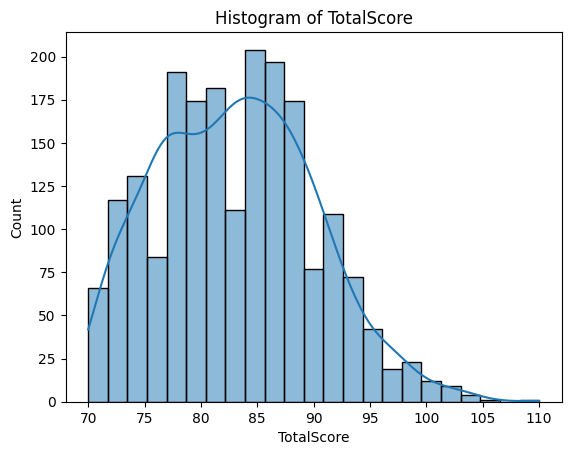

In [66]:
# Histogram
sns.histplot(original_df[y_col], kde=True)
plt.title('Histogram of TotalScore')
plt.show()




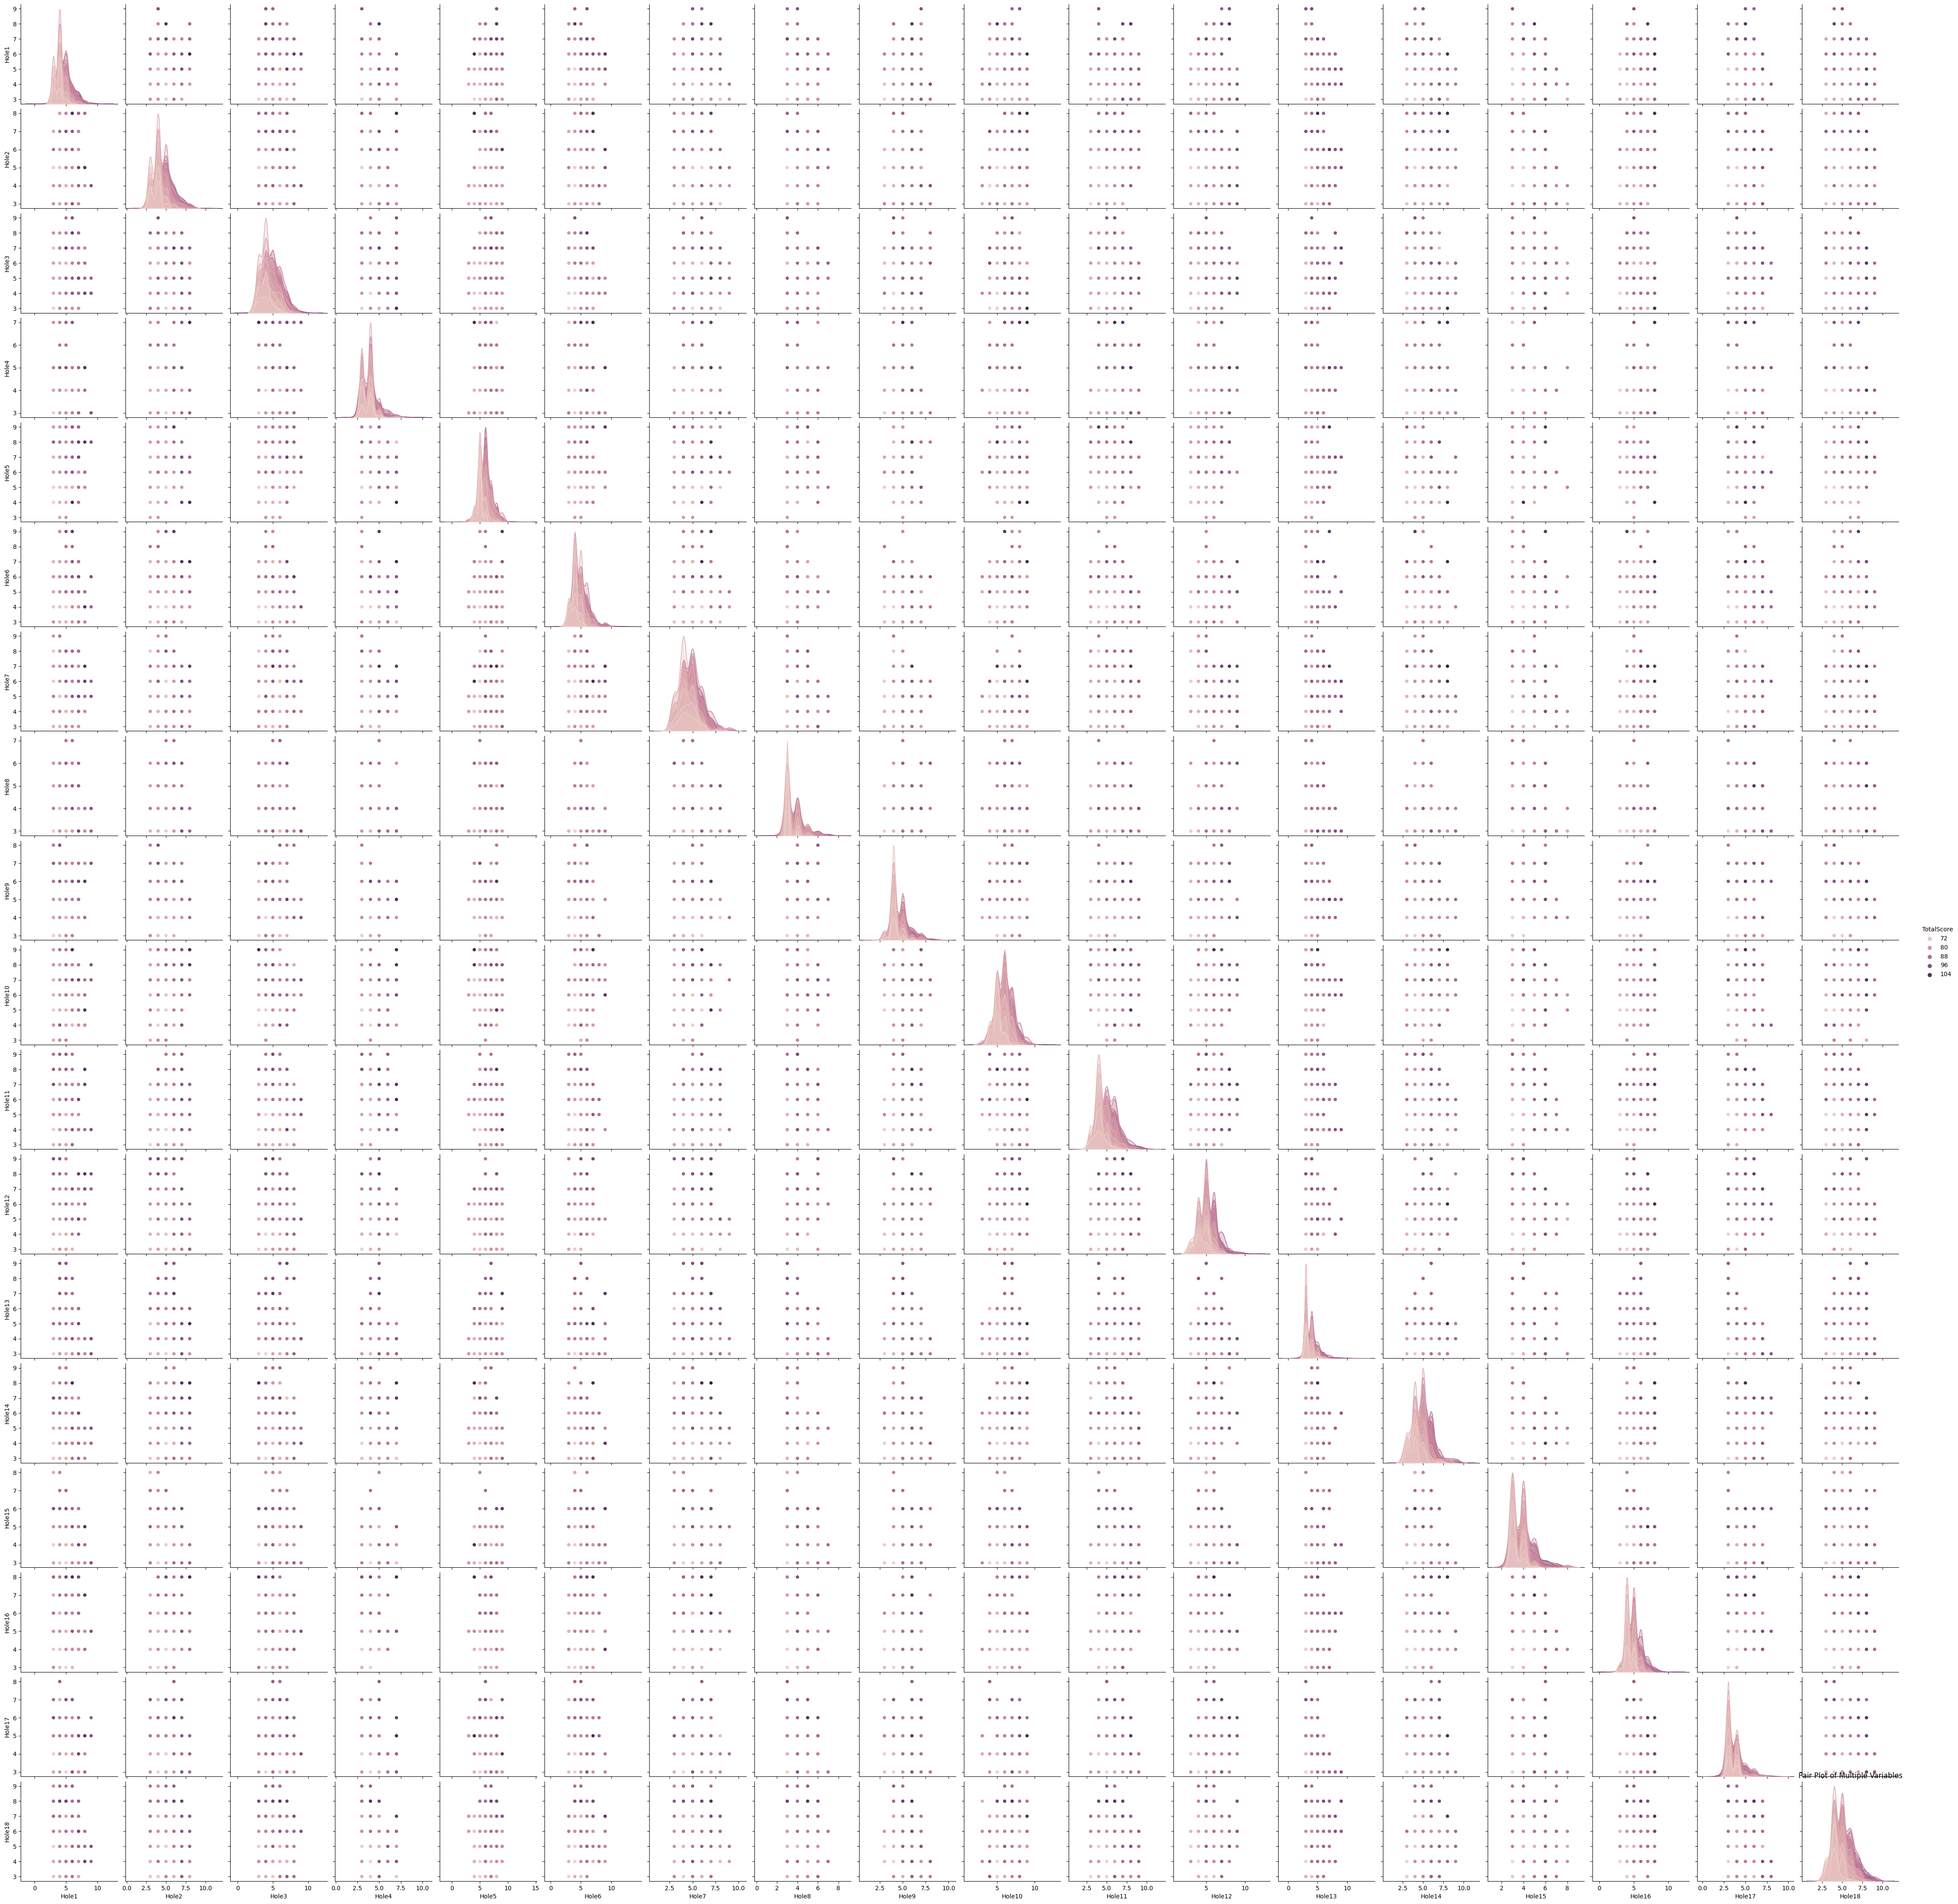

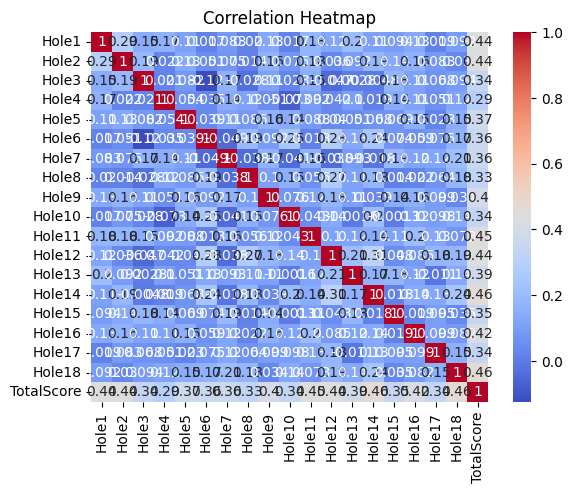

In [21]:
# Pair plot
sns.pairplot(original_df, hue=y_col)
plt.title('Pair Plot of Multiple Variables')
plt.show()

# Heatmap for correlation
correlation_matrix = original_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

###########

At this point we know:
- TotalScore is not normally distributed
- MSE for the original dataset must be better (smaller) than 49.844

------- END EDA----

############

##############################

Neural network

#################################


In [67]:
## Static, hidden layers
def create_model(p_learning_rate
                 , p_dropout_rate
                 , pDfX
                 , p_nb_neuron_input=128
                 , p_activation='relu'
                 , p_kernel_init='he_normal'
                 , p_batch_norm=False
                 ):
    model = Sequential()

    # Input layer
    model.add(Dense(p_nb_neuron_input
                    , input_dim=pDfX.shape[1]
                    , activation=p_activation
                    , kernel_initializer=p_kernel_init
                    , kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)
                    , name='input'
                    ))
    model.add(Dropout(p_dropout_rate))
    if p_batch_norm:
        model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))

    # Layer 1
    model.add(Dense(int(p_nb_neuron_input/2)
                    , activation=p_activation
                    , kernel_initializer=p_kernel_init
                    , kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)
                    , name='hidden_1'
                    ))
    model.add(Dropout(p_dropout_rate))
    if p_batch_norm:
        model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))

    # Layer 2
    model.add(Dense(int(p_nb_neuron_input/4)
                    , activation=p_activation
                    , kernel_initializer=p_kernel_init
                    , kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)
                    , name='hidden_2'
                    ))
    model.add(Dropout(p_dropout_rate))
    if p_batch_norm:
        model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))

    # Output layer
    model.add(Dense(1))

    adam = Adam(lr=p_learning_rate)

    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    return model


In [68]:
## static, 2 hidden layers + merge layer

def create_model_2(p_learning_rate
                   , p_dropout_rate
                   , pDfX, p_nb_neuron_input=128
                   , p_activation='relu'
                   , p_kernel_init='he_normal'
                   , p_batch_norm=False):
    model = Sequential()

    # Input layer
    input_layer = keras.layers.Input(shape=(pDfX.shape[1],))

    # Layer 1
    hidden_layer_1 = Dense(int(p_nb_neuron_input),
                           activation=p_activation,
                           kernel_initializer=p_kernel_init,
                           kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
                           name='hidden_1')(input_layer)
    dropout_1 = Dropout(p_dropout_rate)(hidden_layer_1)
    if p_batch_norm:
        batch_norm_1 = keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(dropout_1)

    # Layer 2
    hidden_layer_2 = Dense(int(p_nb_neuron_input / 2),
                           activation=p_activation,
                           kernel_initializer=p_kernel_init,
                           kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
                           name='hidden_2')(input_layer)
    dropout_2 = Dropout(p_dropout_rate)(hidden_layer_2)
    if p_batch_norm:
        batch_norm_2 = keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(dropout_2)

    # Merge the output of hidden_layer_1 and hidden_layer_2
    merged_layer = keras.layers.Concatenate()([dropout_1, dropout_2])

    # Output layer
    output_layer = keras.layers.Dense(1, activation='relu')(merged_layer)

    adam = Adam(lr=p_learning_rate)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    return model


In [69]:
### plot graphs
def plot_graph_2(p_model_history, p_var_valid, p_var_test, p_arr_legend):
    # Plot MAE
    plt.plot(p_model_history[p_var_valid])
    plt.plot(p_model_history[p_var_test])

    ## Plot loss
    #plt.plot(p_model_history['loss'])
    #plt.plot(p_model_history['val_loss'])

    ## Add labels and legends for MAE and loss
    #plt.legend(['train MAE', 'test MAE', 'train loss', 'test loss'], loc='upper right')
    plt.legend(p_arr_legend, loc='upper right')
    plt.title('Model Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.show()






In [70]:
### fit a model, score, calls plot
def do_analysis(pModel, pXTrain, pYTrain, pXTest, pYTest,
                p_dropout_rate =0.3
                , p_learning_rate=0.001
                , p_epochs =30, p_batch_size=10,
                p_validation_split=0.2, p_verbose=True, p_plot_graph=1):

  ## we fit with train
  model_history = pModel.fit(pXTrain, pYTrain, batch_size=p_batch_size, epochs=p_epochs, validation_split = p_validation_split, verbose=1)

  ## we evaluate model's accuracy (use TEST vars, NOT TRAIN)
  score = pModel.evaluate(pXTest, pYTest, verbose=p_verbose)

  print ('---Summary---')
  print (pModel.summary())
  print("[Loss]: ", score[0])
  print("[MSE]: ", score[1])
  print('-------------')



  if(p_plot_graph):
    #plot_graph(model_history.history)
    #plot_graph_2(model_history.history, 'mae', 'val_mae', ['train MAE', 'test MAE'])
    plot_graph_2(model_history.history, 'mse', 'val_mse', ['train MSE', 'test MSE'])
    plot_graph_2(model_history.history, 'loss', 'val_loss', ['train LOSS', 'test LOSS'])


[score train] 0.0
[score valid] -0.000796875625000304
----[Dummy results]------
Your model must perform at least better than this: 
Root Mean Squared Error - [RMSE]: 7.06
Mean Squared Error - [MSE]: 49.844
----------
Epoch 1/50
103/103 [==============================] - 3s 6ms/step - loss: 6936.5811 - mse: 6932.1553 - val_loss: 6726.1787 - val_mse: 6722.0054
Epoch 2/50
103/103 [==============================] - 0s 4ms/step - loss: 6817.6636 - mse: 6813.6421 - val_loss: 6572.7510 - val_mse: 6568.8569
Epoch 3/50
103/103 [==============================] - 0s 4ms/step - loss: 6628.2412 - mse: 6624.4268 - val_loss: 6363.3853 - val_mse: 6359.6372
Epoch 4/50
103/103 [==============================] - 0s 4ms/step - loss: 6362.0557 - mse: 6358.3594 - val_loss: 6167.0879 - val_mse: 6163.4399
Epoch 5/50
103/103 [==============================] - 0s 4ms/step - loss: 6032.4858 - mse: 6028.8657 - val_loss: 5803.6475 - val_mse: 5800.0513
Epoch 6/50
103/103 [==============================] - 0s 4ms/st

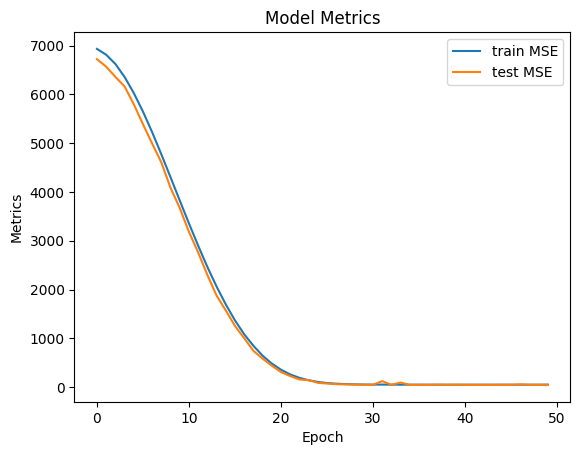

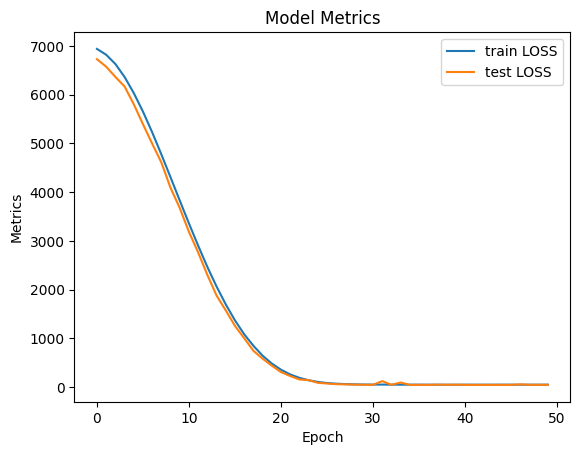

In [71]:
## Model evaluation, original_df
model = create_model (0.0003, 0.45, X_train_orig, p_nb_neuron_input = X_train_orig.shape[1]*2, p_batch_norm=True)
analyze_dummy(original_df, X_train_orig, X_valid_orig, y_train_orig, y_valid_orig)
do_analysis(model, X_train_orig, y_train_orig, X_test_orig
            , y_test_orig #, p_learning_rate =0.0002
            , p_epochs=50, p_verbose=0)

##########

The obtained curves show loss and mse decline over the epochs (the model is learning to predict)

Moreover, the face that train and test curves follow each other closely is a good sign (no over-fitting)

The MSE obtained varies.

Some MSE we got:

42.85

47.85

48.65

...

Never much better than the dummy estimator at 49.84

###########

[score train] 0.0
[score valid] -0.000796875625000304
----[Dummy results]------
Your model must perform at least better than this: 
Root Mean Squared Error - [RMSE]: 7.06
Mean Squared Error - [MSE]: 49.844
----------
Epoch 1/50
103/103 [==============================] - 1s 4ms/step - loss: 3582.8018 - mse: 3579.1345 - val_loss: 531.9393 - val_mse: 528.4147
Epoch 2/50
103/103 [==============================] - 0s 3ms/step - loss: 387.2389 - mse: 383.8379 - val_loss: 11.6715 - val_mse: 8.4107
Epoch 3/50
103/103 [==============================] - 0s 3ms/step - loss: 307.5676 - mse: 304.4251 - val_loss: 12.3563 - val_mse: 9.3159
Epoch 4/50
103/103 [==============================] - 0s 3ms/step - loss: 275.6856 - mse: 272.7177 - val_loss: 18.4213 - val_mse: 15.5187
Epoch 5/50
103/103 [==============================] - 0s 4ms/step - loss: 244.1840 - mse: 241.3217 - val_loss: 11.2325 - val_mse: 8.4074
Epoch 6/50
103/103 [==============================] - 0s 4ms/step - loss: 239.0431 - mse: 23

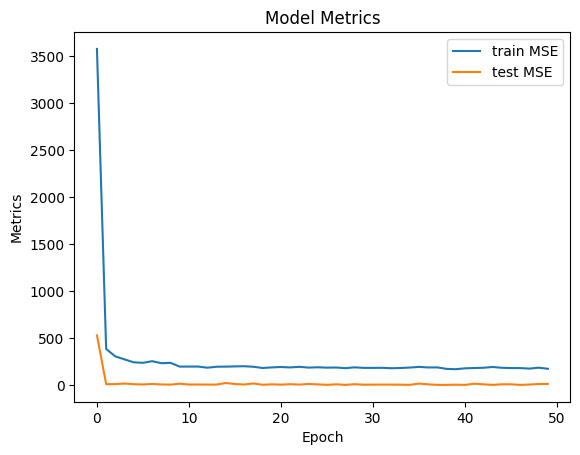

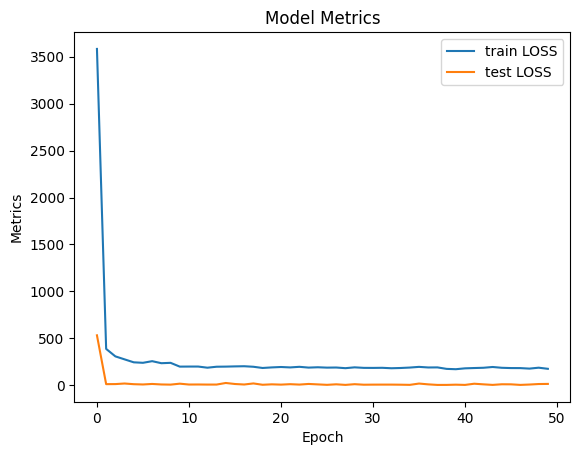

In [72]:
## Model evaluation, original df, model 2 (with merge layer)
model = create_model_2 (0.0003, 0.45, X_train_orig, p_nb_neuron_input = X_train_orig.shape[1]*2, p_batch_norm=True)
analyze_dummy(original_df, X_train_orig, X_valid_orig, y_train_orig, y_valid_orig)
do_analysis(model, X_train_orig, y_train_orig, X_test_orig
            , y_test_orig
            , p_epochs=50, p_verbose=0)

###########

Although the MSE can change at each run, this model for this dataset performs absurdly better than model 1.

Some MSE values obtained:

11.43

1.59

...

always far better than better than 40+

###########

############

Fine tuning with grid search

############

In [105]:
print(X_train_orig.shape[1])
print(X_train_orig.shape[1]*8)
print(X_train_orig.shape[1]*16)

18
144
288


In [121]:
def do_random_search(p_model, p_X_train, p_y_train):
  # Specify the hyperparameter grid for RandomizedSearchCV
  param_grid = {
    'p_learning_rate': [ 0.0005, 0.00045, 0.0003],
    'p_dropout_rate': [0.45, 0.475],

    'p_nb_neuron_input': [
                          #p_X_train.shape[1]
                          #, p_X_train.shape[1]*2
                           p_X_train.shape[1]*24
                          , p_X_train.shape[1]*64
                           ],
    #'p_activation': ['relu', 'tanh'],
    'p_activation': ['relu'],
    'p_kernel_init': ['he_normal', 'glorot_uniform'],
    'p_batch_norm': [True, False]
  }

  '''
model = create_model_2 (0.0003, 0.45, X_train_orig
, p_nb_neuron_input = X_train_orig.shape[1]*2
, p_batch_norm=True)
analyze_dummy(original_df, X_train_orig, X_valid_orig, y_train_orig, y_valid_orig)
do_analysis(model, X_train_orig, y_train_orig, X_test_orig
            , y_test_orig #, p_learning_rate =0.0002
            , p_epochs=50, p_verbose=0)
  '''

  ## Initialize RandomizedSearchCV with the KerasRegressor and hyperparameter grid
  random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=60, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

  ## Fit the RandomizedSearchCV to your data
  random_search.fit(p_X_train, p_y_train)  # Replace X_train and y_train with your training data

  print('----[best params]-----')
  print(random_search.best_params_)
  print('-----[best score]----')
  print(random_search.best_score_)
  print('---------')

  return random_search


In [132]:
## get dependent and independent variables
dfX, dfY = get_dfX_dfY(original_df,y_col)

## create a model
model = KerasRegressor(build_fn=create_model_2, verbose=1, pDfX=dfX)

best_model_rnd_search = do_random_search(model, X_train_orig, y_train_orig)



<ipython-input-132-ec26c143afe7>:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_2, verbose=1, pDfX=dfX)


40/40 [==============================] - 1s 3ms/step - loss: 1680.3623 - mse: 1636.1985
----[best params]-----
{'p_nb_neuron_input': 432, 'p_learning_rate': 0.0005, 'p_kernel_init': 'he_normal', 'p_dropout_rate': 0.475, 'p_batch_norm': False, 'p_activation': 'relu'}
-----[best score]----
-5.248924995975858
---------


Epoch 1/50
103/103 [==============================] - 3s 9ms/step - loss: 1186.1218 - mse: 1144.0265 - val_loss: 42.9199 - val_mse: 3.0266
Epoch 2/50
103/103 [==============================] - 1s 6ms/step - loss: 116.2452 - mse: 77.9547 - val_loss: 39.4532 - val_mse: 2.5879
Epoch 3/50
103/103 [==============================] - 1s 5ms/step - loss: 103.5127 - mse: 67.7002 - val_loss: 45.7883 - val_mse: 10.9427
Epoch 4/50
103/103 [==============================] - 1s 5ms/step - loss: 90.0188 - mse: 55.8592 - val_loss: 34.7636 - val_mse: 1.2276
Epoch 5/50
103/103 [==============================] - 1s 5ms/step - loss: 87.5840 - mse: 54.5172 - val_loss: 33.6104 - val_mse: 0.9528
Epoch 6/50
103/103 [==============================] - 1s 5ms/step - loss: 78.5214 - mse: 46.1582 - val_loss: 32.7231 - val_mse: 0.6230
Epoch 7/50
103/103 [==============================] - 1s 6ms/step - loss: 75.9863 - mse: 44.0921 - val_loss: 34.5903 - val_mse: 2.8597
Epoch 8/50
103/103 [============================

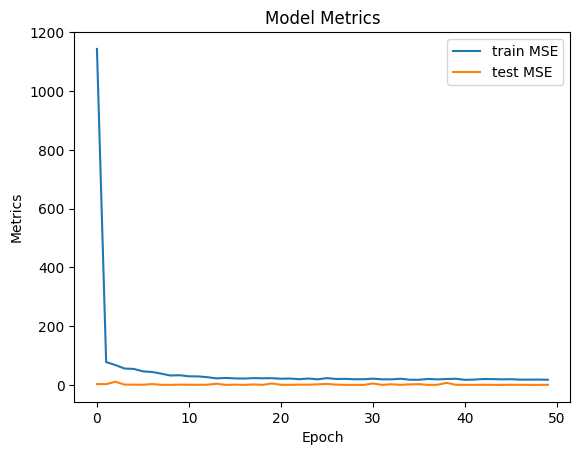

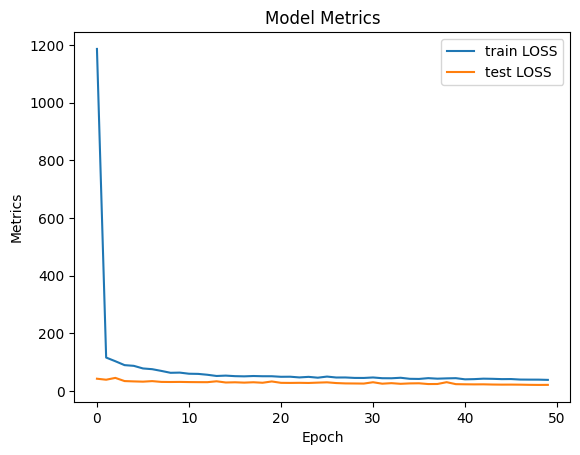

"\n## Train the best model with your training data\nhistory = best_model.fit(\n    X_train_orig,  # Replace with your training data\n    y_train_orig,  # Replace with your training labels\n    epochs=50,     # You can adjust the number of epochs\n    verbose=1,     # Set to 1 for training details, 0 for no details\n    validation_data=(X_valid_orig, y_valid_orig)  # Replace with your validation data\n)\n\nplot_graph_2(history.history, 'mse', 'val_mse', ['train MSE', 'test MSE'])\nplot_graph_2(history.history, 'loss', 'val_loss', ['train LOSS', 'test LOSS'])\n"

In [138]:
# Train the best model with the best hyperparameters
best_params = best_model_rnd_search.best_params_
best_learning_rate = best_params['p_learning_rate']
best_dropout_rate = best_params['p_dropout_rate']
best_nb_neuron_input = best_params['p_nb_neuron_input']
best_activation = best_params['p_activation']
best_kernel_init = best_params['p_kernel_init']
best_batch_norm = best_params['p_batch_norm']

best_model = create_model_2(
    p_learning_rate=best_learning_rate,
    p_dropout_rate=best_dropout_rate,
    p_nb_neuron_input=best_nb_neuron_input,
    p_activation=best_activation,
    p_kernel_init=best_kernel_init,
    p_batch_norm=best_batch_norm,
    pDfX=dfX  # Assuming dfX is your input data
)


do_analysis(best_model
            , X_train_orig
            , y_train_orig
            , X_test_orig
            , y_test_orig
            , p_epochs=50
            , p_verbose=0)




In [144]:
from tensorflow import summary
### Predictions with the (supposed) best model on PRODUCTION dataframe

dfX_prod, dfY_prod = get_dfX_dfY(production_df2, y_col)
y_pred = pd.DataFrame( best_model.predict(dfX_prod), columns=[y_col])


print('--[summary]--')
print(y_pred.describe())
print ('----y_pred------')
print(y_pred)

19/19 [==============================] - 0s 3ms/step
--[summary]--
       TotalScore
count  600.000000
mean    45.514633
std     21.341993
min      6.470901
25%     28.397891
50%     45.405312
75%     63.115067
max     95.359123
----y_pred------
     TotalScore
0     43.297295
1     39.138351
2     45.501133
3     35.579197
4     39.158566
..          ...
595   25.364401
596   19.666414
597   15.131549
598   12.292386
599   12.292386

[600 rows x 1 columns]


#####

RandomSearch:

The obtained graph shows no overfitting

The obtained MSE:
[MSE]:  0.44004082679748535

is far better than the dummy estimator

We could continue on and on, but I consider this satisfying enough

#####

In [125]:
def do_random_search_pca(p_model, p_X_train, p_y_train):
  # Specify the hyperparameter grid for RandomizedSearchCV
  param_grid = {
    'p_learning_rate': [ 0.0005, 0.00045, 0.00025],
    'p_dropout_rate': [0.45, 0.475],

    'p_nb_neuron_input': [
                          p_X_train.shape[1]
                          , p_X_train.shape[1]*2
                          #, p_X_train.shape[1]*24
                          #, p_X_train.shape[1]*64
                           ],
    #'p_activation': ['relu', 'tanh'],
    'p_activation': ['relu'],
    'p_kernel_init': ['he_normal', 'glorot_uniform'],
    'p_batch_norm': [True, False]
  }

  '''
model = create_model_2 (0.0003, 0.45, X_train_orig
, p_nb_neuron_input = X_train_orig.shape[1]*2
, p_batch_norm=True)
analyze_dummy(original_df, X_train_orig, X_valid_orig, y_train_orig, y_valid_orig)
do_analysis(model, X_train_orig, y_train_orig, X_test_orig
            , y_test_orig #, p_learning_rate =0.0002
            , p_epochs=50, p_verbose=0)
  '''

  ## Initialize RandomizedSearchCV with the KerasRegressor and hyperparameter grid
  random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=60, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

  ## Fit the RandomizedSearchCV to your data
  random_search.fit(p_X_train, p_y_train)  # Replace X_train and y_train with your training data

  print('----[best params]-----')
  print(random_search.best_params_)
  print('-----[best score]----')
  print(random_search.best_score_)
  print('---------')

  return random_search


In [126]:
### PCA

n_components = 2
pca = PCA(n_components = n_components)

## get dependent and independent variables
dfX, dfY = get_dfX_dfY(original_df,y_col)

pca_data = pca.fit_transform(dfX)

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=pca_data, columns=[f'PC{i}' for i in range(1, n_components + 1)])

df_pca_with_y = pd.concat([df_pca, dfY], axis=1)

X_train_orig_pca, X_valid_orig_pca, X_test_orig_pca, y_train_orig_pca, y_valid_orig_pca, y_test_orig_pca = get_train_test(df_pca_with_y)

## create a model
model = KerasRegressor(build_fn=create_model_2, verbose=1, pDfX=df_pca)

best_model_pca = do_random_search_pca(model, X_train_orig_pca, y_train_orig_pca)

<ipython-input-126-965cc603d426>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_2, verbose=1, pDfX=df_pca)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=60. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


40/40 [==============================] - 1s 2ms/step - loss: 6913.8374 - mse: 6913.7119
----[best params]-----
{'p_nb_neuron_input': 4, 'p_learning_rate': 0.00025, 'p_kernel_init': 'he_normal', 'p_dropout_rate': 0.45, 'p_batch_norm': False, 'p_activation': 'relu'}
-----[best score]----
-6720.6873917746325
---------


pandas.core.frame.DataFrame

########################

END grid search

######################
